In [1]:
%matplotlib inline
import sys
sys.path.insert(1, '../../../../script/')
import math
import collections
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
#import missingno as msno

from collections import defaultdict
from scipy.stats.stats import pearsonr

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix

import pydotplus
from sklearn import tree
from IPython.display import Image

import cleaning_class as cl
import cleaning_test as cl_test
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'imblearn'

In [2]:
def report(results, n_top=3):
    configurations = {}
    c_i = 0
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean training score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_train_score'][candidate],
                  results['std_train_score'][candidate]))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            configurations[c_i] = results['params'][candidate]
            c_i += 1 
    return configurations

def report_multiple(results, n_top=3, scoring = 'roc_auc'):
    configurations = {}
    c_i = 0
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_' + scoring] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean training score:", end = '')
            print("   roc_auc: {0:.3f} (std: {1:.3f})".format(
                  results['mean_train_roc_auc'][candidate],
                  results['std_train_roc_auc'][candidate]), end = '')
            print(", Accuracy: {0:.3f} (std: {1:.3f})".format(
                  results['mean_train_accuracy'][candidate],
                  results['std_train_accuracy'][candidate]), end = '')
            print(", f1: {0:.3f} (std: {1:.3f})".format(
                  results['mean_train_f1'][candidate],
                  results['std_train_f1'][candidate]))


            print("Mean validation score:", end = '')
            print(" roc_auc: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_roc_auc'][candidate],
                  results['std_test_roc_auc'][candidate]), end = '')
            print(", Accuracy: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_accuracy'][candidate],
                  results['std_test_accuracy'][candidate]), end = '')
            print(", f1: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_f1'][candidate],
                  results['std_test_f1'][candidate]))

            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            configurations[c_i] = results['params'][candidate]
            c_i += 1 
    return configurations

# Check the feature used for classification

ne ho selezionate solo alcune, speravo cambiasse qualcosa, possiamo scrivere che dopo diversi test sul decision tree ci siamo resi conto che queste hanno più importanza rispetto alle altre, le abbiamo selezionate per essere sicuri di non andare ada incorrere nella curse of dimensionality

In [3]:
df = pd.read_csv('../../data/training.csv') 
cl.cleaning(df)
df.columns

Index(['IsBadBuy', 'Auction', 'VehicleAge', 'Make', 'Color', 'WheelTypeID',
       'VehOdo', 'Size', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentRetailAveragePrice', 'VNST', 'VehBCost', 'WarrantyCost'],
      dtype='object')

In [4]:
df = pd.get_dummies(df)
df = pd.get_dummies(df, columns=['WheelTypeID'])
df.columns

Index(['IsBadBuy', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentRetailAveragePrice', 'VehBCost', 'WarrantyCost',
       'Auction_ADESA',
       ...
       'VNST_SC', 'VNST_TN', 'VNST_TX', 'VNST_UT', 'VNST_VA', 'VNST_WA',
       'VNST_WV', 'WheelTypeID_1.0', 'WheelTypeID_2.0', 'WheelTypeID_3.0'],
      dtype='object', length=110)

# Split in train and validation

validation condiviso con le varie tecniche per il confronto, fatto con lo stratified per tenere tutto bilanciato con le classi.

In [5]:
attributes = [col for col in df.columns if col != 'IsBadBuy']
x = df[attributes].values
y = df['IsBadBuy']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, stratify=y)

# - Undersampling
uso from RandomUnderSampler: 
https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html

### GRIDSEARCH

In [6]:
param_list = {'criterion': ['gini', 'entropy'],
              'max_depth': [None] + list(np.arange(2, 10)),
              'min_samples_split': list(np.arange(2, 40)),
              'min_samples_leaf': list(np.arange(1, 40)),
             }
new_params = {'decisiontreeclassifier__' + key: param_list[key] for key in param_list}

skf = StratifiedKFold(n_splits=3)
clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)
imba_pipeline = make_pipeline(RandomUnderSampler(), clf)
scoring = ['accuracy', 'f1', 'roc_auc' ]

random_search = RandomizedSearchCV(imba_pipeline, param_distributions=new_params, n_iter=1000, cv=skf, scoring=scoring, refit = 'roc_auc', n_jobs = 4, verbose = 1, return_train_score=True)
random_search.fit(x_train, y_train)
cnfs = report_multiple(random_search.cv_results_, n_top=3, scoring = 'roc_auc')

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   37.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  3.2min


Model with rank: 1
Mean training score:   roc_auc: 0.678 (std: 0.005), Accuracy: 0.638 (std: 0.019), f1: 0.290 (std: 0.007)
Mean validation score: roc_auc: 0.672 (std: 0.004), Accuracy: 0.635 (std: 0.017), f1: 0.284 (std: 0.004)
Parameters: {'decisiontreeclassifier__min_samples_split': 29, 'decisiontreeclassifier__min_samples_leaf': 37, 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__criterion': 'entropy'}

Model with rank: 2
Mean training score:   roc_auc: 0.678 (std: 0.003), Accuracy: 0.558 (std: 0.052), f1: 0.279 (std: 0.001)
Mean validation score: roc_auc: 0.670 (std: 0.002), Accuracy: 0.554 (std: 0.059), f1: 0.276 (std: 0.007)
Parameters: {'decisiontreeclassifier__min_samples_split': 29, 'decisiontreeclassifier__min_samples_leaf': 15, 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__criterion': 'gini'}

Model with rank: 3
Mean training score:   roc_auc: 0.686 (std: 0.002), Accuracy: 0.628 (std: 0.009), f1: 0.289 (std: 0.004)
Mean validation score: 

[Parallel(n_jobs=4)]: Done 3000 out of 3000 | elapsed:  3.9min finished


### Perform Clustering

In [10]:
rus = RandomUnderSampler()
x_u_train_resampled, y_u_train_resampled = rus.fit_resample(x_train, y_train)

In [11]:
models_u = []
y_pred_vals_u = []
y_pred_trains_u = []
hyper_ps = random_search.cv_results_
for cnf in cnfs.values():
    criterion = cnf['decisiontreeclassifier__criterion']
    max_depth = cnf['decisiontreeclassifier__max_depth']
    min_samples_split = cnf['decisiontreeclassifier__min_samples_split']
    min_samples_leaf = cnf['decisiontreeclassifier__min_samples_leaf']
    clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    clf = clf.fit(x_u_train_resampled, y_u_train_resampled)
    models_u.append(clf)
    y_pred = clf.predict(x_val)
    y_pred_tr = clf.predict(x_u_train_resampled)
    y_pred_vals_u.append(y_pred)
    y_pred_trains_u.append(y_pred_tr)   

### Analyze the classification results

In [13]:
roc_auc_models_u_val = []
for i in range(0,len(cnfs)):
    print("model {}".format(i))
    print('Train Accuracy %s' % accuracy_score(y_u_train_resampled, y_pred_trains_u[i]))
    print('Train F1-score %s' % f1_score(y_u_train_resampled, y_pred_trains_u[i], average=None))

    fpr, tpr, _ = roc_curve(y_u_train_resampled, y_pred_trains_u[i])
    roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(y_u_train_resampled, y_pred_trains_u[i], average=None)
    print("Train roc_auc: {}".format(roc_auc))
    print()
    
    print('Test Accuracy %s' % accuracy_score(y_val, y_pred_vals_u[i]))
    print('Test F1-score %s' % f1_score(y_val, y_pred_vals_u[i], average=None))
    
    fpr, tpr, _ = roc_curve(y_val, y_pred_vals_u[i])
    roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(y_val, y_pred_vals_u[i], average=None)
    print("Test roc_auc: {}".format(roc_auc))
    roc_auc_models_u_val.append(roc_auc)
 
    print(classification_report(y_val, y_pred_vals_u[i]))
    print(confusion_matrix(y_val, y_pred_vals_u[i]))

model 0
Train Accuracy 0.6218415417558887
Train F1-score [0.64587929 0.59430278]
Train roc_auc: 0.6218415417558887

Test Accuracy 0.671399102050722
Test F1-score [0.78663725 0.28548813]
Test roc_auc: 0.6149811514452399
              precision    recall  f1-score   support

           0       0.92      0.69      0.79     14480
           1       0.19      0.54      0.29      2002

    accuracy                           0.67     16482
   macro avg       0.55      0.61      0.54     16482
weighted avg       0.83      0.67      0.73     16482

[[9984 4496]
 [ 920 1082]]
model 1
Train Accuracy 0.625695931477516
Train F1-score [0.64187666 0.60798385]
Train roc_auc: 0.6256959314775161

Test Accuracy 0.6539254944788254
Test F1-score [0.77209525 0.28125   ]
Test roc_auc: 0.6123538754063615
              precision    recall  f1-score   support

           0       0.92      0.67      0.77     14480
           1       0.19      0.56      0.28      2002

    accuracy                           0.65 

In [14]:
for i in range(0,len(cnfs)):
    print("model {} - roc_auc: {}".format(i, roc_auc_models_u_val[i]))

model 0 - roc_auc: 0.6149811514452399
model 1 - roc_auc: 0.6123538754063615
model 2 - roc_auc: 0.6132207226475183


### Choose the best model

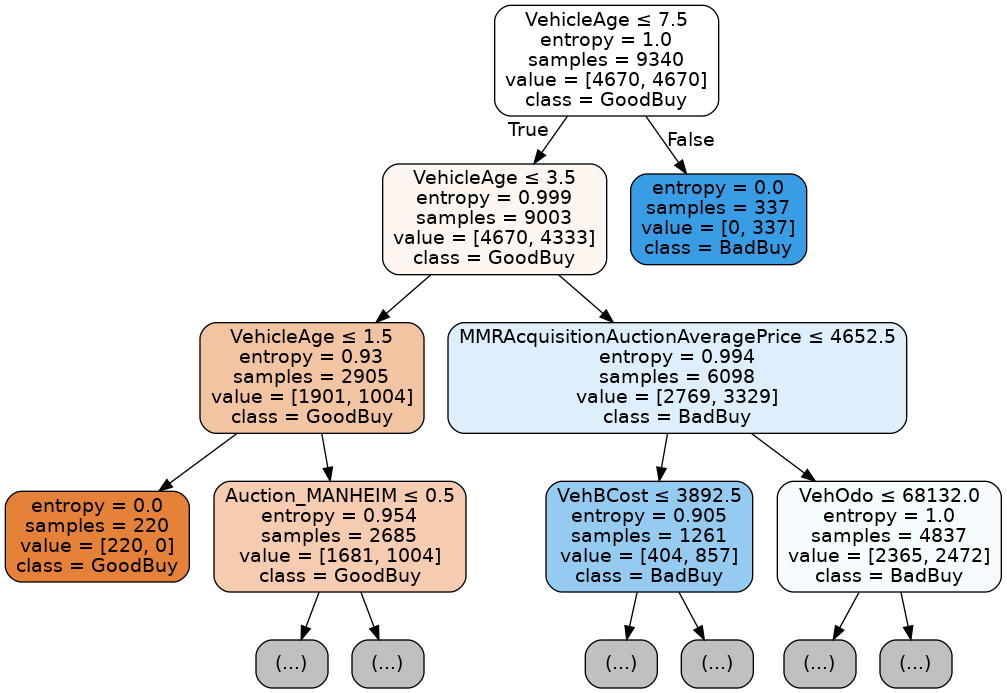

In [15]:
dot_data = tree.export_graphviz(models_u[0], out_file=None,
                                feature_names=attributes,
                                class_names=['BadBuy' if x == 1 else 'GoodBuy' for x in clf.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

Evaluate the performance

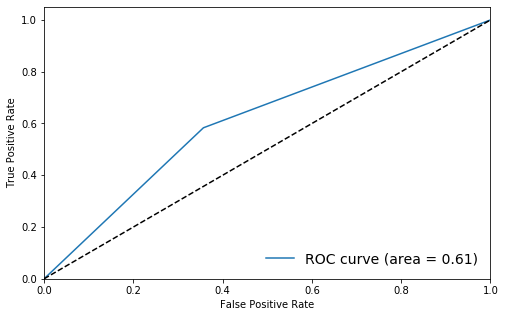

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc_models_u_val[0]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.tick_params(axis='both', which='major')
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

# - Uppersampling
rimetto insieme x_train e y_train per poter aumentare i record della classe minoritaria (lo 1) uso SMOTE: 
https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html

### GRIDSEARCH

In [17]:
param_list = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(np.arange(2, 20)),
    'min_samples_split': list(np.arange(2, 40)),
    'min_samples_leaf': list(np.arange(2, 40)),
    'min_impurity_decrease': [0.75e-6, 0.5e-6, 1e-6]
    }
new_params = {'decisiontreeclassifier__' + key: param_list[key] for key in param_list}

skf = StratifiedKFold(n_splits=3)
clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)
imba_pipeline = make_pipeline(SMOTE(sampling_strategy= 1.0, random_state=42), clf)
scoring = ['accuracy', 'f1', 'roc_auc' ]

#grid_imba = RandomizedSearchCV(imba_pipeline, param_distributions=new_params, cv=skf, n_iter=400, return_train_score=True, scoring='f1', n_jobs = 4, verbose = 1)
grid_imba = RandomizedSearchCV(imba_pipeline, param_distributions=new_params, n_iter=1000, cv=skf, scoring=scoring, refit = 'roc_auc', n_jobs = 4, verbose = 1, return_train_score=True)


grid_imba.fit(x, y)
cnfs = report_multiple(grid_imba.cv_results_, n_top=3, scoring = 'roc_auc')

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  8.0min
/home/alessandro/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 14.8min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 23.6min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 34.0min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 46.3min
[Parallel(n_jobs=4)]: Done 3000 out of 3000 | elapsed: 57.3min finished


Model with rank: 1
Mean training score:   roc_auc: 0.676 (std: 0.003), Accuracy: 0.875 (std: 0.003), f1: 0.202 (std: 0.001)
Mean validation score: roc_auc: 0.652 (std: 0.008), Accuracy: 0.873 (std: 0.002), f1: 0.196 (std: 0.013)
Parameters: {'decisiontreeclassifier__min_samples_split': 39, 'decisiontreeclassifier__min_samples_leaf': 29, 'decisiontreeclassifier__min_impurity_decrease': 5e-07, 'decisiontreeclassifier__max_depth': 8, 'decisiontreeclassifier__criterion': 'entropy'}

Model with rank: 2
Mean training score:   roc_auc: 0.675 (std: 0.003), Accuracy: 0.875 (std: 0.003), f1: 0.202 (std: 0.002)
Mean validation score: roc_auc: 0.652 (std: 0.007), Accuracy: 0.874 (std: 0.002), f1: 0.196 (std: 0.014)
Parameters: {'decisiontreeclassifier__min_samples_split': 6, 'decisiontreeclassifier__min_samples_leaf': 18, 'decisiontreeclassifier__min_impurity_decrease': 5e-07, 'decisiontreeclassifier__max_depth': 8, 'decisiontreeclassifier__criterion': 'entropy'}

Model with rank: 3
Mean training 

### Perform Clustering

In [18]:
sm = SMOTE(sampling_strategy=1.0, random_state=42)
x_o_train_resampled, y_o_train_resampled = sm.fit_sample(x_train, y_train)

In [19]:
models_o = []
y_pred_vals_o = []
y_pred_trains_o = []
hyper_ps = grid_imba.cv_results_
for cnf in cnfs.values():
    criterion = cnf['decisiontreeclassifier__criterion']
    max_depth = cnf['decisiontreeclassifier__max_depth']
    min_samples_split = cnf['decisiontreeclassifier__min_samples_split']
    min_samples_leaf = cnf['decisiontreeclassifier__min_samples_leaf']
    clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    clf = clf.fit(x_o_train_resampled, y_o_train_resampled)
    models_o.append(clf)
    y_pred = clf.predict(x_val)
    y_pred_tr = clf.predict(x_o_train_resampled)
    y_pred_vals_o.append(y_pred)
    y_pred_trains_o.append(y_pred_tr)   

In [20]:
roc_auc_models_o_val = []
for i in range(0,len(cnfs)):
    print("model {}".format(i))
    print('Train Accuracy %s' % accuracy_score(y_o_train_resampled, y_pred_trains_o[i]))
    print('Train F1-score %s' % f1_score(y_o_train_resampled, y_pred_trains_o[i], average=None))
    
    fpr, tpr, _ = roc_curve(y_o_train_resampled, y_pred_trains_o[i])
    roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(y_o_train_resampled, y_pred_trains_o[i], average=None)
    print("Train roc_auc: {}".format(roc_auc))
    print()

    print('Test Accuracy %s' % accuracy_score(y_val, y_pred_vals_o[i]))
    print('Test F1-score %s' % f1_score(y_val, y_pred_vals_o[i], average=None))

    fpr, tpr, _ = roc_curve(y_val, y_pred_vals_o[i])
    roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(y_val, y_pred_vals_o[i], average=None)
    print("Test roc_auc: {}".format(roc_auc))
    roc_auc_models_o_val.append(roc_auc)
    
    print(classification_report(y_val, y_pred_vals_o[i]))
    print(confusion_matrix(y_val, y_pred_vals_o[i]))

model 0
Train Accuracy 0.883483794583395
Train F1-score [0.89238214 0.8729813 ]
Train roc_auc: 0.883483794583395

Test Accuracy 0.8630020628564494
Test F1-score [0.92498339 0.21159218]
Test roc_auc: 0.5563718394864804
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     14480
           1       0.35      0.15      0.21      2002

    accuracy                           0.86     16482
   macro avg       0.62      0.56      0.57     16482
weighted avg       0.83      0.86      0.84     16482

[[13921   559]
 [ 1699   303]]
model 1
Train Accuracy 0.8840017759360663
Train F1-score [0.89287374 0.87352761]
Train roc_auc: 0.8840017759360663

Test Accuracy 0.8636087853415848
Test F1-score [0.92533546 0.21288515]
Test roc_auc: 0.5569323632168935
              precision    recall  f1-score   support

           0       0.89      0.96      0.93     14480
           1       0.36      0.15      0.21      2002

    accuracy                           0

### Analyze the classification performance

In [21]:
for i in range(0,len(cnfs)):
    print("model {} - roc_auc: {}".format(i, roc_auc_models_o_val[i]))

model 0 - roc_auc: 0.5563718394864804
model 1 - roc_auc: 0.5569323632168935
model 2 - roc_auc: 0.5563718394864804


### Choose the best model

Visualize the decision tree

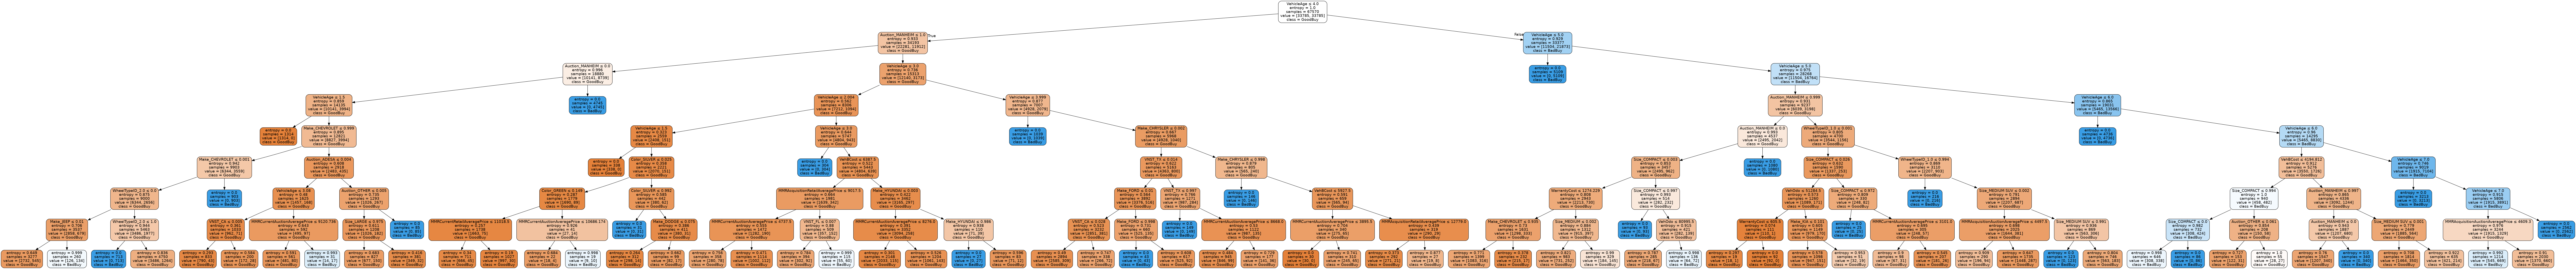

In [24]:
dot_data = tree.export_graphviz(models_o[1], out_file=None,
                                feature_names=attributes,
                                class_names=['BadBuy' if x == 1 else 'GoodBuy' for x in clf.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=8)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

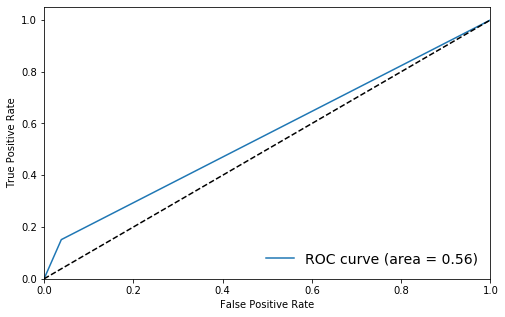

In [26]:
%matplotlib inline
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc_models_o_val[2]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.tick_params(axis='both', which='major')
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

# Model evaluation on test set
il miglior modello è quello con la tecnica dell'undersampling, valutiamo il tutto sul test set

In [218]:
df_test = pd.read_csv('../../data/test.csv') 
cl_test.cleaning(df_test)
df_test.columns

Index(['IsBadBuy', 'Auction', 'VehicleAge', 'WheelTypeID', 'VehOdo', 'Size',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentRetailAveragePrice', 'VNST',
       'VehBCost', 'WarrantyCost'],
      dtype='object')

In [219]:
df_test = pd.get_dummies(df_test)
df_test = pd.get_dummies(df_test, columns=['WheelTypeID'])
df_test.columns

Index(['IsBadBuy', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentRetailAveragePrice', 'VehBCost', 'WarrantyCost',
       'Auction_ADESA', 'Auction_MANHEIM', 'Auction_OTHER', 'Size_COMPACT',
       'Size_CROSSOVER', 'Size_LARGE', 'Size_LARGE SUV', 'Size_LARGE TRUCK',
       'Size_MEDIUM', 'Size_MEDIUM SUV', 'Size_SMALL SUV', 'Size_SMALL TRUCK',
       'Size_SPECIALTY', 'Size_SPORTS', 'Size_VAN', 'VNST_AL', 'VNST_AR',
       'VNST_AZ', 'VNST_CA', 'VNST_CO', 'VNST_FL', 'VNST_GA', 'VNST_IA',
       'VNST_ID', 'VNST_IL', 'VNST_IN', 'VNST_KY', 'VNST_LA', 'VNST_MA',
       'VNST_MD', 'VNST_MI', 'VNST_MN', 'VNST_MO', 'VNST_MS', 'VNST_NC',
       'VNST_NE', 'VNST_NH', 'VNST_NJ', 'VNST_NM', 'VNST_NV', 'VNST_NY',
       'VNST_OH', 'VNST_OK', 'VNST_OR', 'VNST_PA', 'VNST_SC', 'VNST_TN',
       'VNST_TX', 'VNST_UT', 'VNST_VA', 'VNST_WA', 'VNST_WV',
       'WheelTypeID_1.0', 'WheelTypeID_2.0',

In [222]:
attributes = [col for col in df_test.columns if col != 'IsBadBuy']
x_test = df_test[attributes].values
y_test = df_test['IsBadBuy']

In [223]:
y_pred_test = models_u[0].predict(x_test)

Test Accuracy 0.5678953137845986
Test F1-score [0.69274614 0.27212926]
              precision    recall  f1-score   support

           0       0.92      0.55      0.69     12828
           1       0.17      0.67      0.27      1768

    accuracy                           0.57     14596
   macro avg       0.55      0.61      0.48     14596
weighted avg       0.83      0.57      0.64     14596

Confusion matrix, without normalization
[[6433 6395]
 [ 502 1266]]
Normalized confusion matrix
[[0.50148114 0.49851886]
 [0.28393665 0.71606335]]


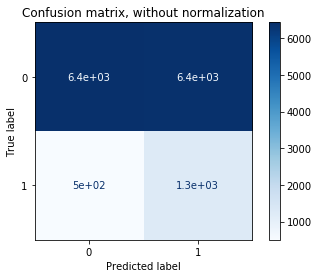

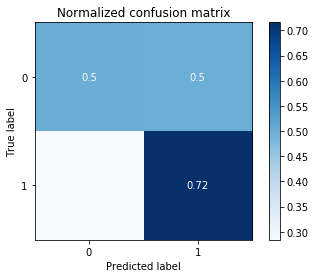

In [224]:
print('Test Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('Test F1-score %s' % f1_score(y_test, y_pred_test, average=None))
print(classification_report(y_test, y_pred_test))

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(models[0], x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()


In [225]:
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_test, y_pred_test, average=None)
print("model {} - roc_auc: {}".format(0, roc_auc))
roc_auc_models.append(roc_auc)

model 0 - roc_auc: 0.6105557589661754


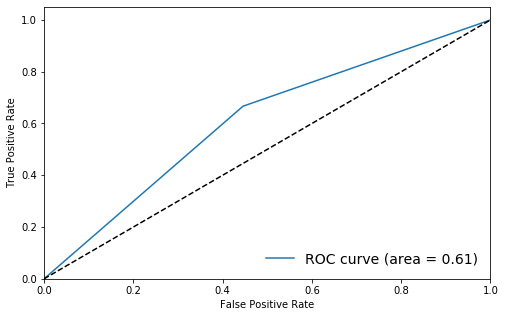

In [226]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.tick_params(axis='both', which='major')
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()